# 1. Introduction

Accurate ship classification from aerial imagery is critical for a wide range of maritime applications—from port security and traffic monitoring to search‐and‐rescue operations and naval intelligence. However, real‐world platforms such as medium‑ or low-altitude UAVs frequently produce images of varying quality, due to motion blur, atmospheric haze, sensor noise, and occlusion. A classifier that produces only a single “hard” label can be dangerously overconfident when presented with low‑quality frames, potentially leading to misidentification of vessel types and consequential operational errors.

In this notebook, we present a reproducible pipeline that (1) quantifies image quality via a no‑reference composite metric, (2) trains deep classifiers that are explicitly encouraged to lower confidence on degraded inputs via entropy regularization, and (3) implements quality‑aware conformal prediction to provide set‑valued outputs with formal coverage guarantees. Our contributions are:  
- **Composite Quality Scoring**: combining different quality measures measures into a single score.  
- **Entropy‑Regularized Training**: a simple loss augmentation that forces the model to “know when it doesn’t know,” yielding more cautious confidence on low‑quality images.  
- **Quality‑Dependent Conformal Prediction**: per‐quality‑bin calibration of nonconformity thresholds, so that prediction sets expand under poor visibility while remaining tight when imagery is clear.

# 2. Dataset Preparation

In this section we load and clean the **Fine-Grained Ship Classification** (FGSC-23) dataset introduce by Zhang et al. (2020) to produce a high‑quality, balanced dataset for training and evaluation.  We will:

1. Load the raw images and inspect class distributions.  
2. Remove near‑duplicate samples to prevent memorization bias.  
3. Exclude grayscale, occluded, or tiny‑ship images, and finalize the class counts.

## 2.1. Data Loading and Overview

We begin by loading the FGSC-23 ship classification dataset directly from the Hugging Face Datasets Hub. Key steps:

- **Class enumeration**  
  Use the dataset's metadata to obtain fine‑grained ship labels and their corresponding class indices.  
- **Sample counts**  
  Compute and display the number of images per class to reveal any imbalance.  
- **Representative examples**  
  Show a small random subset of images for each class to verify visual consistency and label correctness.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

ds = load_dataset("jbourcier/fgsc23")

In [28]:
# Mapping integer labels (0–22) to human-readable ship class names from Zhang et al. (2023)
label_map = {
    0:  "Non-ship",
    1:  "Aircraft carrier",
    12:  "Destroyer",
    16:  "Landing craft",
    17:  "Frigate",
    18:  "Amphibious transport dock",
    19:  "Cruiser",
    20:  "Tarawa-class amphibious assault ship",
    21:  "Amphibious assault ship",
    22:  "Command ship",
    2: "Submarine",
    3: "Medical ship",
    4: "Combat boat",
    5: "Auxiliary ship",
    6: "Container ship",
    7: "Car carrier",
    8: "Hovercraft",
    9: "Bulk carrier",
    10: "Oil tanker",
    11: "Fishing boat",
    13: "Passenger ship",
    14: "Liquefied gas ship",
    15: "Barge"
}

In [29]:
import pandas as pd

# Extract labels from the train split
labels = ds['train']['label']

# Map integer labels to string labels
string_labels = [label_map[lbl] for lbl in labels]

# Compute class counts
class_counts = pd.Series(string_labels).value_counts().sort_index()

# Display as a DataFrame, sorted by count descending
class_distribution = pd.DataFrame({
    'Class Index': [list(label_map.values()).index(name) for name in class_counts.index],
    'Class Name': class_counts.index,
    'Count': class_counts.values,
}).sort_values('Count', ascending=False).reset_index(drop=True)
print(class_distribution)

    Class Index                            Class Name  Count
0             2                             Destroyer    542
1             0                              Non-ship    484
2            17                          Bulk carrier    343
3             4                               Frigate    295
4             6                               Cruiser    293
5            10                             Submarine    238
6            13                        Auxiliary ship    225
7             1                      Aircraft carrier    166
8            18                            Oil tanker    165
9             8               Amphibious assault ship    154
10           12                           Combat boat    143
11           16                            Hovercraft    120
12            3                         Landing craft    108
13           19                          Fishing boat    102
14           14                        Container ship    100
15           21         

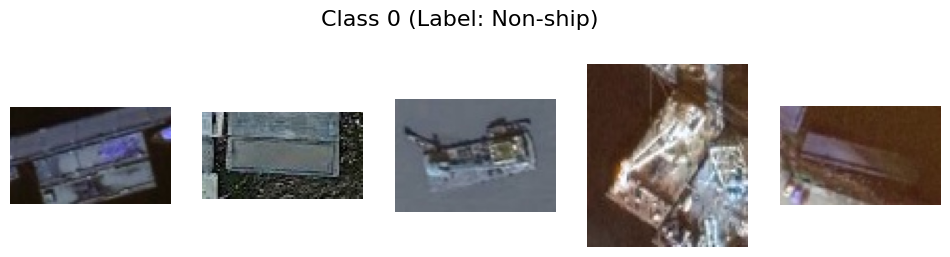

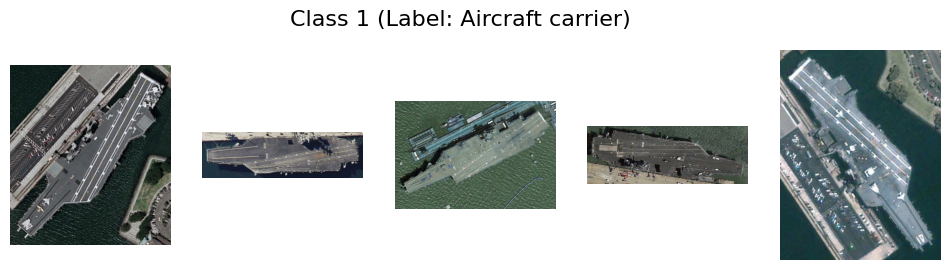

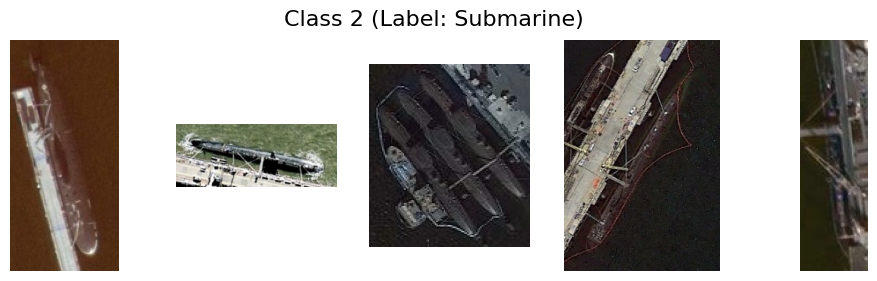

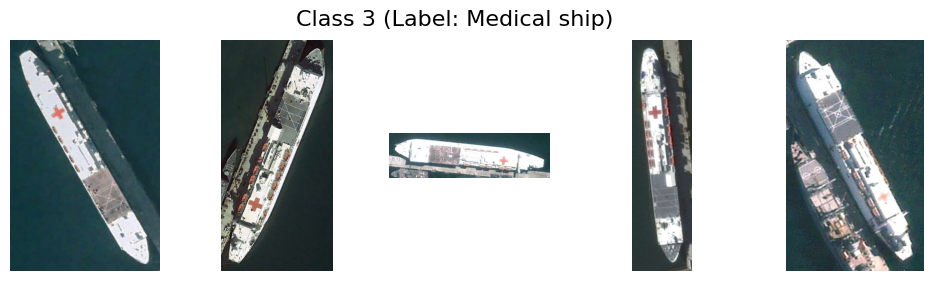

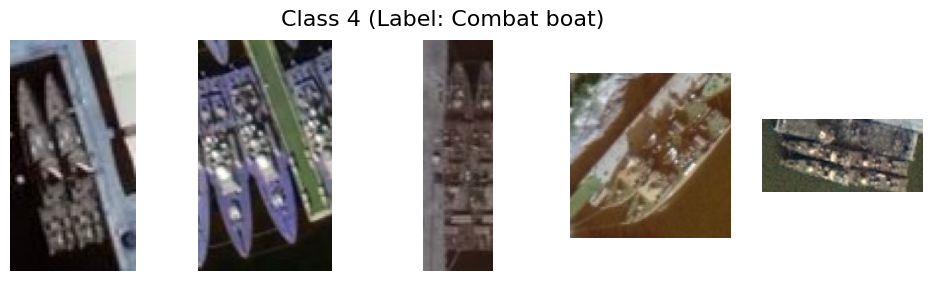

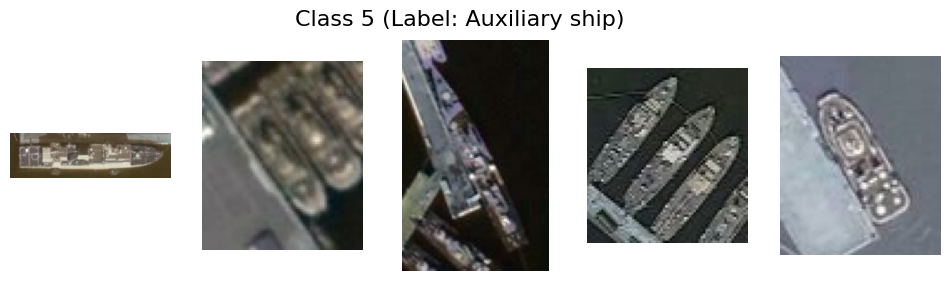

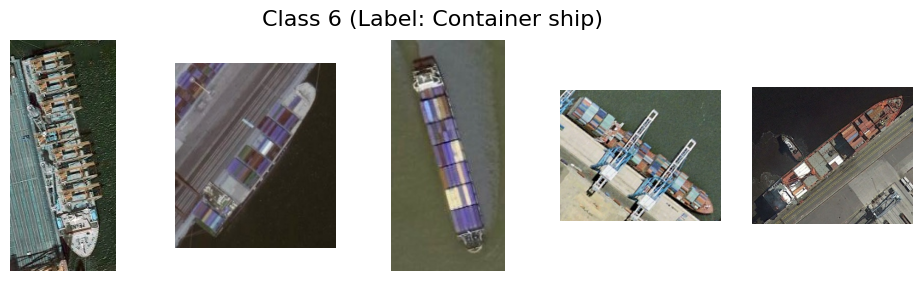

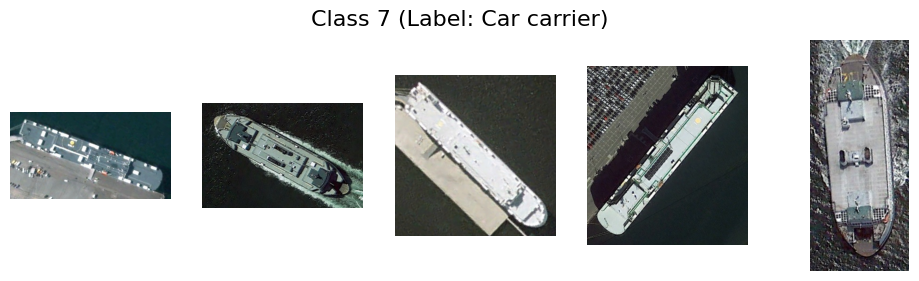

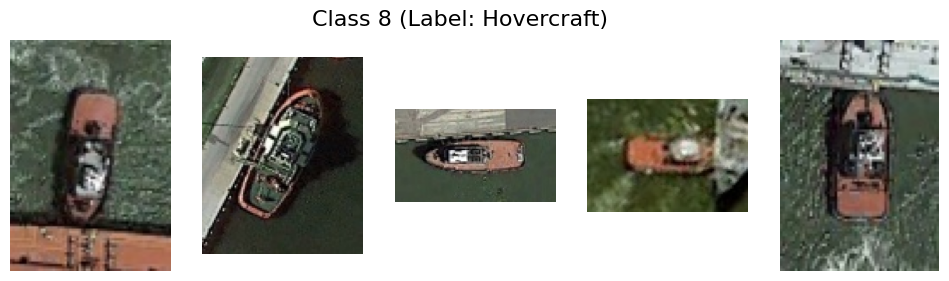

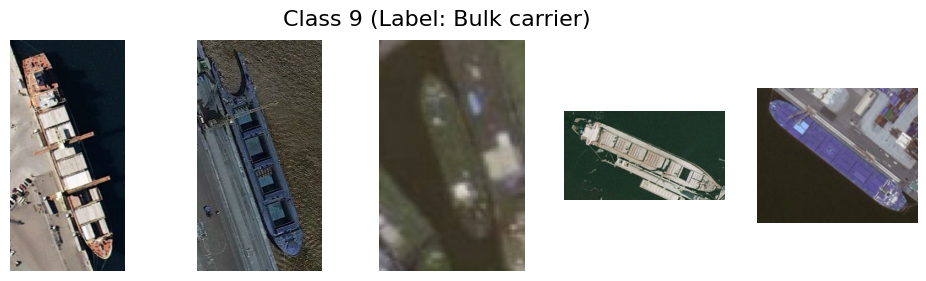

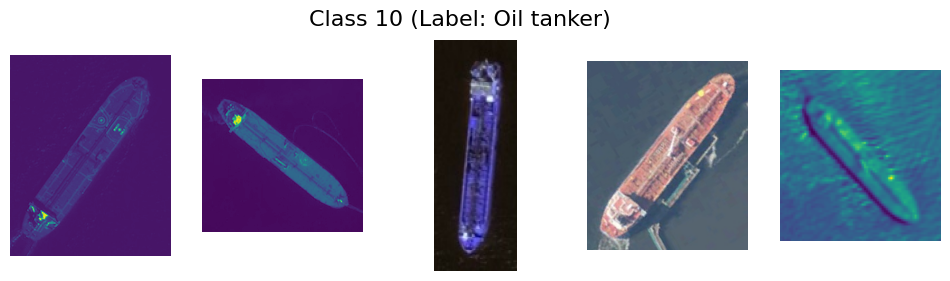

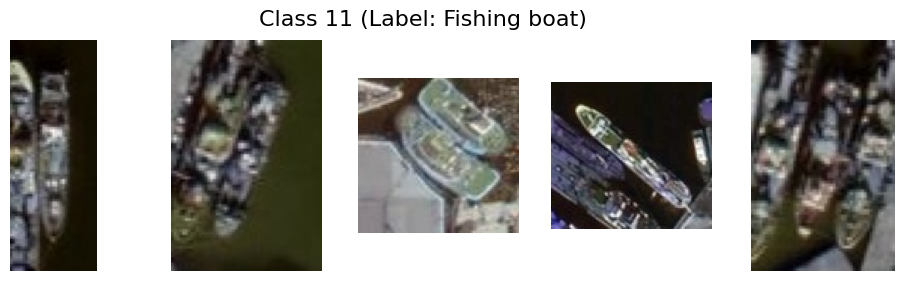

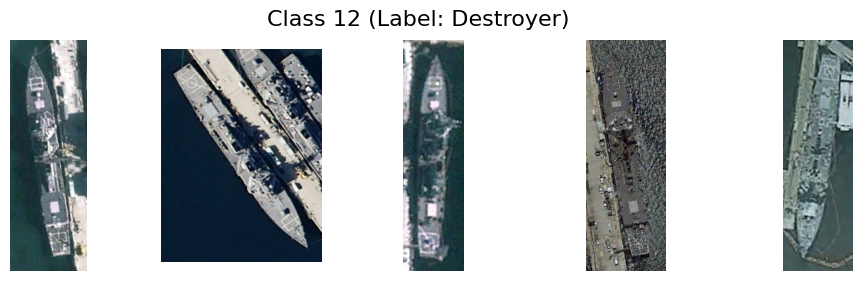

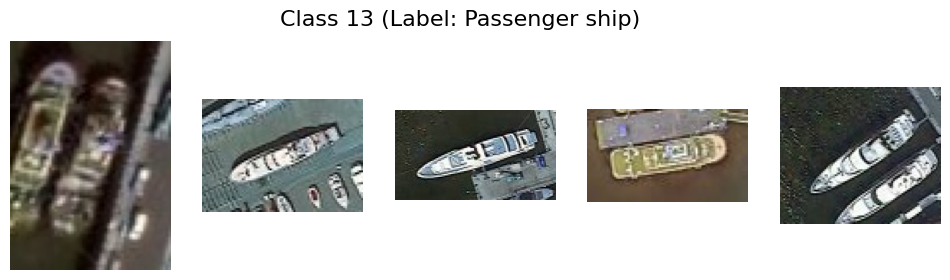

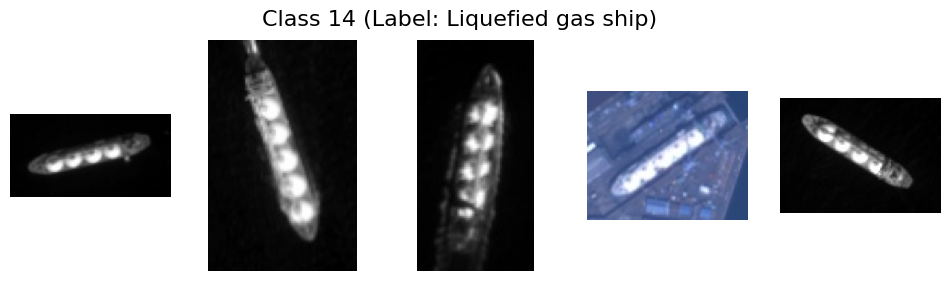

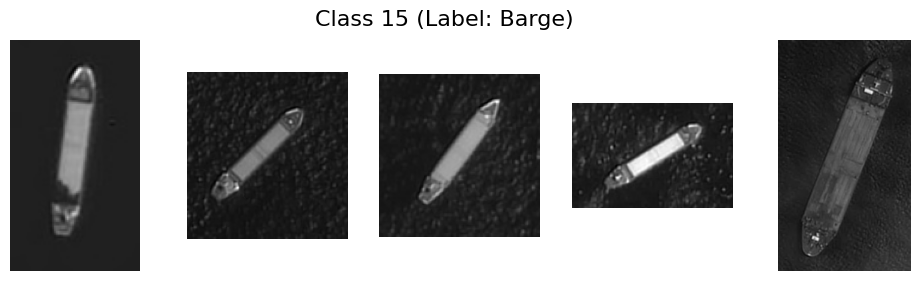

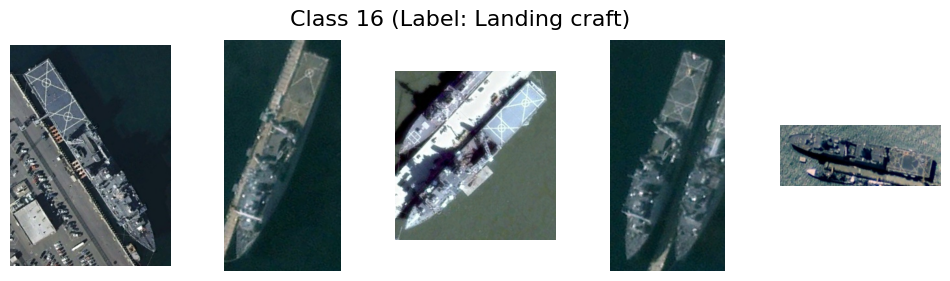

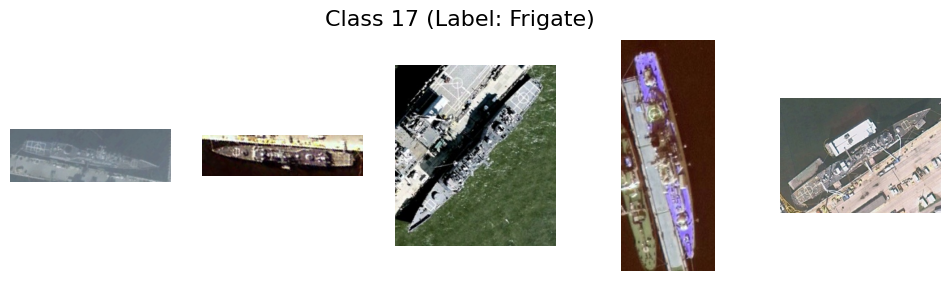

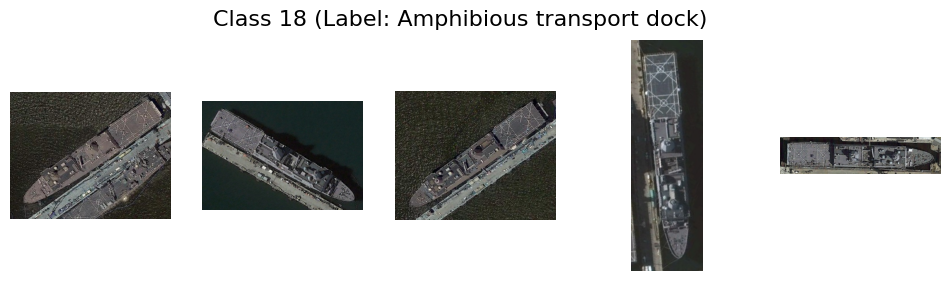

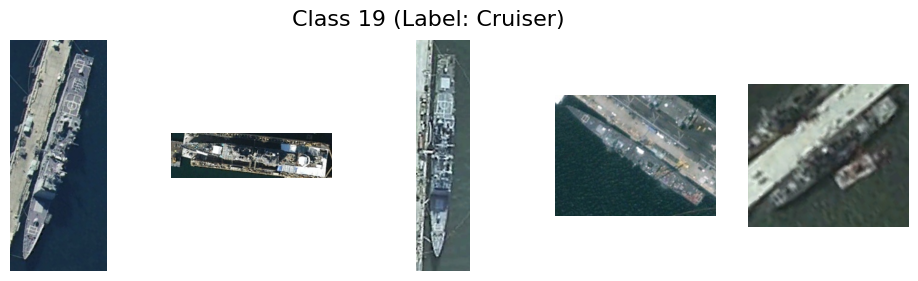

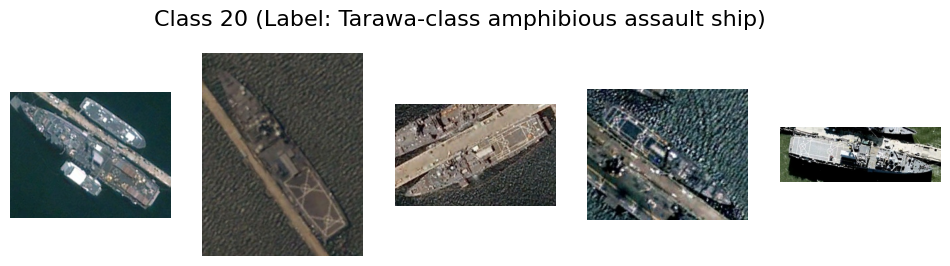

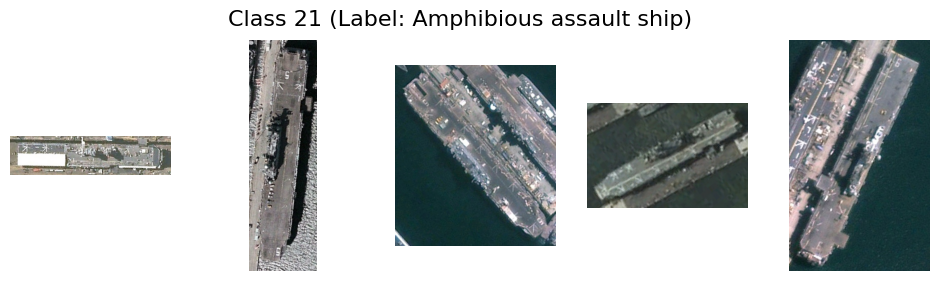

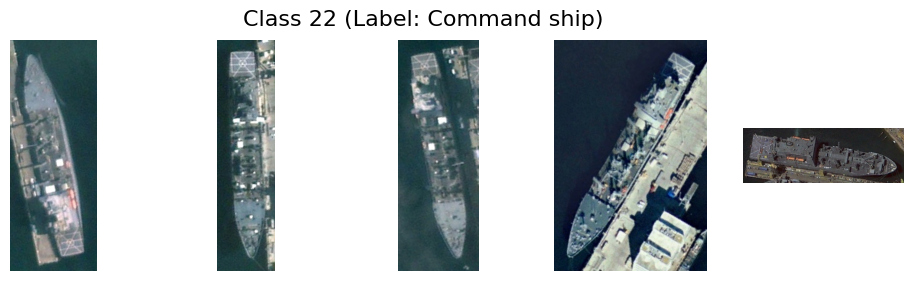

In [30]:
import numpy as np

import matplotlib.pyplot as plt

# Get unique class indices
unique_classes = np.sort(class_distribution['Class Index'].values)

for class_idx in unique_classes:
    # Get indices of images belonging to this class
    indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    # Randomly select up to 5 indices
    selected = np.random.choice(indices, size=min(5, len(indices)), replace=False)
    # Load images
    images = [ds['train'][int(i)]['image'] for i in selected]
    
    # Plot images
    plt.figure(figsize=(12, 3))
    for j, img in enumerate(images):
        plt.subplot(1, 5, j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Class {class_idx} (Label: {label_map[class_idx]})", fontsize=16)
    plt.show()

## 2.2. Deduplication of Near‑Identical Samples

## 2.2. Deduplication of Near‑Identical Samples

To avoid over‑optimistic performance from duplicate or near‑duplicate images, we apply a perceptual hashing pipeline:

1. **Perceptual hash computation**  
   Compute a compact hash (e.g. pHash) for each image to capture its visual fingerprint.  
2. **Grouping by hash distance**  
   Identify groups of images whose Hamming distance falls below a chosen threshold.  
3. **Pruning duplicates**  
   Within each group, retain a single representative image and remove the rest.

We will report:  
- The total number of images removed overall and per class.  
- Examples of image pairs (or triplets) flagged as duplicates.

- Rationale and method  
- Number of removals and class impact  
- Examples of removed pairs  

## 2.3. Removal of Undesired Samples

## 2.3. Removal of Undesired Samples

Finally, we filter out images that do not meet our minimum quality criteria:

- **Grayscale images**  
  Remove any sample lacking color information.  
- **Occluded or truncated ships**  
  Exclude images where the vessel is heavily occluded or cut off at the frame border.  
- **Tiny ship instances**  
  Discard images in which the ship occupies too few pixels to allow reliable classification.  
- **Class size threshold**  
  Ensure each remaining class has a sufficient number of high‑quality samples.

We conclude by presenting the final per‑class distribution, confirming that all categories have adequate representation for downstream training, calibration, and testing.

- Grayscale, occluded, or tiny ships
- Final class distribution and counts

# 3. Geometric Preprocessing

In this section we standardize the spatial dimensions and orientation of every image so that the classifier sees a consistent input format.  

## 3.1. Resizing, Padding, and Aspect‑Ratio Preservation

All images are resized so that their longer side matches a target resolution (e.g. 448 px), then zero‑padded on the shorter side to produce square inputs.  This avoids both distortion and cropping of important ship features.  

- **Resize step:**  
  Scale each image by the same factor in both dimensions so that 
  \(\max(\text{width},\text{height}) = \text{target\_size}\).  
- **Padding step:**  
  Compute the remaining pixels on each side and pad equally (randomly if desired) with black borders.  
- **Benefits:**  
  - Preserves the native aspect ratio of the ship  
  - Ensures all inputs are identical shape for batching  
  - Avoids cropping out ship extremities  

> **Examples**:  
> *Left*: original varied‐size images ∣ *Right*: resized + padded to 448×448

- Code pipeline
- Before/after image examples

## 3.2. Orientation Correction (Optional)

While most FGSCM‑52 images are roughly upright, some ships appear at extreme rotations or mirror‑flipped due to sensor orientation.  We optionally:

- **Auto‑rotate** based on EXIF metadata, if available  
- **Normalize orientation** by detecting horizon lines or using a small ship‑detector model  
- **Augment** with horizontal flips to increase rotational robustness  

This step is optional—rotations can also be handled at training time via data augmentation—but may improve performance if the deployment imagery has a consistent “up” direction.

- When and why to rotate or flip

# 4. Image‑Quality Simulation & Measurement

In this section we simulate realistic degradations on our ship imagery and then compute no‑reference metrics to quantify each frame’s visibility.  These quality scores will drive both entropy‑regularized training and quality‑aware conformal calibration.

## 4.1. Synthetic Degradation Methods

To emulate the types of blur and low contrast seen in UAV or ship‑borne footage, we randomly apply two distortions:

- **Motion & Defocus Blur**  
  We convolve images with a Gaussian kernel of varying radius \(\sigma\) (e.g. 0–10 px) to mimic camera shake, focus drift, or platform vibration.

- **Haze Simulation**  
  We overlay a semi‑transparent veiling layer (or use a dark‑channel synthesis) to reproduce atmospheric scattering, sea spray, or low‑contrast fog.

Both degradations are applied at random per image according to user‑specified parameters (blur probability, haze intensity), yielding a mixed‐quality dataset for downstream processing.

- Motion & defocus blur
- Haze simulation
- Mask‑based occlusion

## 4.2. No‑Reference Quality Metrics

For every image—original and degraded—we compute a suite of no‑reference quality measures:

1. **Sharpness** (Variance of Laplacian)  
   \(\displaystyle \mathrm{Sharpness} = \operatorname{Var}\bigl(\nabla^2 I\bigr)\)  
   Lower values indicate heavier blur.

2. **Compression Artifacts** (BRISQUE Score)  
   A learned, data‑driven score in \([0,100]\); higher → more blocking and ringing.

3. **Haze Index** (Mean Dark‑Channel)  
   \(\displaystyle \mathrm{Haze} = \mathrm{mean}\bigl(\min_{c\in\{R,G,B\}} I_c\bigr)\) after local erosion; higher → more haze.

4. **Occlusion Ratio** (Cloud/Mask Fraction)  
   Fraction of pixels above a brightness threshold, used to estimate cloud cover or physical masking.

We will:

- **Plot histograms** of each metric **before vs. after** synthetic degradation.  
- **Display example pairs** of original and degraded images, annotated with their computed metrics.

These quality scores form the basis for our entropy‐regularization weights and for defining conformal calibration bins in Section 6.  

- Sharpness (variance of Laplacian)  
- Compression artefacts (PIQE/BRISQUE)  
- Haze index (dark‑channel prior)  
- Cloud/occlusion measure  

## 4.3. Composite Quality Score

While each no‑reference metric captures a distinct degradation mode, we need a single, unified proxy **Q** ∈ [0,1] for downstream calibration and training. We compute **Q** as follows:

1. **Min–Max Normalization**  
   - For each raw metric _m_, compute  
     `m_norm = (m – m_min) / (m_max – m_min)`  
   - If “higher is worse” (compression, haze, occlusion), invert:  
     `m_norm = 1 – m_norm`

2. **Gated Fusion**  
   - Define the three “clean” factors:  
     ```python
     sharp_n     = normalized sharpness
     brisque_inv = 1 - brisque_n       # compression inverted
     haze_inv    = 1 - haze_n          # haze inverted
     ```
   - Compute a weighted core score:  
     ```python
     core = w1*sharp_n + w2*brisque_inv + w3*haze_inv
     # with w1 + w2 + w3 = 1
     ```
   - Apply cloud gating so that full occlusion → zero quality:  
     ```python
     quality_score = (1 - cloud_n) * core
     # if cloud_n == 1.0, then quality_score == 0
     ```

3. **Geometric‑Mean Alternative**  
   As a smooth “AND” of all four factors, take their weighted geometric mean:  
   ```python
   # define cloud_free = 1 - cloud_n
   factors = [sharp_n, brisque_inv, haze_inv, cloud_free]
   weights = [w1, w2, w3, w4]  # sum to 1
   log_Q = sum(w * np.log(f + 1e-6) for w, f in zip(weights, factors))
   quality_score = np.exp(log_Q)

   This ensures any near‑zero factor drives quality_score toward zero.

4. **Illustrations**

   - Histogram of quality_score before vs. after synthetic degradation
   - Example images annotated with their composite score

This composite quality index Q will be used to:

   - Weight the entropy regularizer in Section 5.2
   - Define per‑bin conformal thresholds in Section 6.2

- Metric normalization  
- Fusion strategy (e.g. gated or geometric mean)  
- Score distributions and illustrative examples  

# 5. Classification Experiments

In this section we train and evaluate deep neural networks on our processed ship imagery, both with and without entropy regularization to enforce caution on low‑quality inputs. We compare multiple architectures and report accuracy, confusion matrices, and the relationship between image quality and model confidence.

## 5.1. Data Splitting

We partition the cleaned, preprocessed dataset into three disjoint subsets:

- **Training set (≈70 %)**  
  Used to fit the network parameters.  
- **Validation/Calibration set (≈15 %)**  
  Used both for early‑stopping and for computing conformal nonconformity thresholds per quality bin.  
- **Test set (≈15 %)**  
  Held out until the final evaluation to report unbiased accuracy and uncertainty metrics.

Splits are **stratified** by (super)class to preserve class balance. We will display:

- Number of images per class in each split  
- A table or bar chart summarizing sample counts 

- Stratified train/validation/calibration/test  
- Sample counts per class and split  

## 5.2. Model Architectures and Training

We implement and compare three convolutional backbones:

1. **ResNet‑18** (baseline)  
2. **EfficientNet‑B0** (lighter, better calibrated)  
3. **MobileNetV3‑Large** (mobile‑optimized)

For each model we train under two regimes:

- **Standard Cross‑Entropy**  
  `loss = CrossEntropy(logits, labels)`  

- **Entropy Regularization**  
  ```python
  # per‑sample entropy H = –∑ p·log p
  # weight w = (sigma / max_sigma)^k
  loss = CE_loss – λ * mean(w * H)
  where λ and k are hyperparameters to encourage higher entropy on heavily obscured images.

We will show:

Training & Validation Curves
Epoch‑wise accuracy and loss for each model+regime.

Hyperparameters
Learning rate, batch size, number of epochs, entropy weight λ.

- Baseline CNNs (e.g. ResNet‑18, EfficientNet‑B0, and MobileNet-V3)
- Entropy regularization for quality sensitivity (with and without)
- Training curves (train/val accuracy per epoch)  
- Comparison of 3× different models 

## 5.3. Evaluation on Held‑Out Data

On the test split, we report:

Overall Accuracy and Confusion Matrix for each model+regime.

Scatter Plot of quality_score vs. model confidence (true‑class probability), with points colored by correct/incorrect classification, for both validation and test sets.

Calibration Metrics (e.g. Expected Calibration Error) to quantify how well confidence aligns with accuracy.

These results will illustrate how entropy regularization and choice of backbone affect both raw performance and the model’s sensitivity to image quality.

- Overall accuracy and confusion matrices  
- Scatter: quality score vs. true‑class probability (val & test)  
- Correct vs. incorrect coloring

# 6. Conformal Prediction for Uncertainty

Once we have a trained, entropy‑regularized classifier, we wrap it in a conformal predictor to obtain **set‑valued** outputs with formal coverage guarantees.

## 6.1. Global Conformal Thresholds

1. **Nonconformity Score**  
   For each calibration sample \((x_i, y_i)\), compute  
   ```python
   p = softmax(model(x_i))
   score_i = 1 - p[y_i]    # lower = more confident in true label

2. **Quantile Calibration**
Choose a target miscoverage level 
𝛼
α (e.g. 0.1 for 90 % coverage).
Compute the 
(
1
−
𝛼
)
(1−α)-quantile of 
{
 
score
𝑖
}
{score 
i
​
 } over the entire calibration set:

q_global = np.quantile(scores, 1 - alpha)

3. **Prediction Sets**
At inference, for a new image 
𝑥
x, form the set

S(x) = { c : 1 - softmax(model(x))[c] <= q_global }
This set is guaranteed to contain the true label with probability ≥ 
1
−
𝛼
1−α across all quality levels combined.

- Nonconformity definition  
- Coverage and set‐size trade‑off  

6.1.1. Global Coverage and Set Size
Coverage Curve: fraction of test samples where 
𝑦
∈
𝑆
(
𝑥
)
y∈S(x).

Average Set Size: mean 
∣
𝑆
(
𝑥
)
∣
∣S(x)∣ over test images.

We will plot these as horizontal lines or single points to compare against quality‐aware methods.

## 6.2. Quality‑Dependent Buckets

A single global threshold may be too tight on low-quality images (under-coverage)
or too loose on high-quality ones (oversized sets). We address this by calibrating per-quality-bin.

Bin Definition
Divide the composite quality score Q ∈ [0,1] into B contiguous bins:
   bins  = np.linspace(0, 1, B+1)
   labels = [f"bin{i}" for i in range(B)]
   cal_df["q_bin"] = pd.cut(cal_df["quality_score"], bins=bins, labels=labels)

Per-Bin Calibration
For each bin b:
  scores_b = [score_i for i in cal_indices if q_bin_i == b]
  q_b      = np.quantile(scores_b, 1 - alpha)

Adaptive Prediction Sets
At inference, for a new image x:
   1. Compute Q(x) and assign it to bin b
   2. Use threshold q_b to form the set:
       S(x) = { c : 1 - p[c] <= q_b }
  This guarantees coverage ≥ (1 - alpha) within each quality bin.

### 6.2.1. Visualizing Thresholds and Performance

Threshold vs. Bin
Plot {q_b} as a function of the midpoint of each quality bin,
with a horizontal line for the global q_global.

Coverage by Bin
For each bin b:
  cov_b = mean( y_i in S(x_i) for test samples where q_bin_i == b )

Average Set Size by Bin
For each bin b:
  avg_size_b = mean( |S(x_i)| for test samples where q_bin_i == b )

Comparison
Show that quality-dependent calibration preserves the target coverage
across all bins, while a global threshold fails on extreme low-/high-quality images.

- Defining quality bins  
- Per‑bin thresholds vs. global  
- Coverage and average set size as a function of quality  

# 7. Discussion & Future Work

## 7.1. Insights and Limitations

## 7.2. Extensions (multi‑task blur estimation, ensembles, real UAV data)

# References